# Test models

## Initialization

In [21]:
import os
import pyvdirs.dirs as dirs
import sys
sys.path.insert(0, dirs.SYSTEM_HOME)
sys.path.insert(0, os.path.join(dirs.SYSTEM_HOME, "ToyExample"))
from socket import gethostname

import torch
import numpy as np
import json
import matplotlib.pyplot as plt

from ToyExample.toy_example import do_test
import pyvtools.text as vtext

### Parameters

In [2]:
test_batch_size = 2**14
test_seed = 7

# series = ["18_Statistics", "19_ACIDParams", "21_Repetitions", "23_NormalizedLogits"]
series = ["25_ACIDParams_00"]
# series = ["23_NormalizedLogits"]

results_filename = "TestResults_25_ACIDParams_00.json"
# results_filename = "TestResults_23.json"

### Auxiliary definitions

In [3]:
get_path = lambda series : os.path.join(dirs.MODELS_HOME, "ToyExample", series)

host_id = gethostname()
other_hosts = vtext.filter_by_string_must(list(dirs.check_directories_file().keys()), [host_id,"else"], must=False)

results_filepath = os.path.join(dirs.RESULTS_HOME, results_filename)

series_folders = {}
for s in series:
    series_path = get_path(s)
    contents = os.listdir(series_path)
    folders = [c for c in contents if os.path.isdir(os.path.join(series_path, c))]
    folders = vtext.filter_by_string_must(folders, ["Failed", "Old"], must=False)
    series_folders[s] = folders

## Run test and collect results

### If needed, run

In [9]:
test_results = {}

for s in series:

    series_path = get_path(s)
    log_files = ["log_"+f+".txt" for f in series_folders[s]]
    assert all([os.path.isfile(os.path.join(series_path, f)) for f in log_files]), "Some logs have not been found"

    test_results[s] = {}
    for folder, log_file in zip(series_folders[s], log_files):

        log_filepath = os.path.join(series_path, log_file)

        files = os.listdir(os.path.join(series_path, folder))
        net_file = vtext.filter_by_string_must(files, "learner")[0]
        EMA_file = "".join(net_file.split("learner"))

        net_filepath = os.path.join(series_path, folder, net_file)
        EMA_filepath = os.path.join(series_path, folder, EMA_file)

        with open(log_filepath, "r") as f:
            acid = False
            for i, line in enumerate(f):
                if "ACID = True" in line:
                    acid = True
                if "Guide model loaded from" in line or i>70: 
                    break
        if "Guide model loaded from" in line:
            guide_line = line
            guide_filepath = guide_line.split("Guide model loaded from ")[-1].split("\n")[0]
            for h in other_hosts:
                guide_filepath = guide_filepath.replace(dirs.check_directories_file()[h]["models_home"], dirs.MODELS_HOME)
        else:
            guide_filepath = None

        folder_results = do_test(
            net_filepath, ema_path=EMA_filepath, guide_path=guide_filepath, acid=acid, 
            classes='A', P_mean=-2.3, P_std=1.5, sigma_max=5, depth_sep=5,
            n_samples=test_batch_size, batch_size=test_batch_size, 
            test_outer=True, test_mandala=True,
            guidance_weight=3,
            seed=test_seed, generator=None,
            log_filename=log_filepath,
            device=torch.device('cuda'))
        
        test_results[s][folder] = folder_results

100%|██████████| 1/1 [00:07<00:00,  7.43s/it]


In [46]:
with open(results_filepath, "w") as file:
    json.dump({"test_batch_size":test_batch_size,
               "test_seed":test_seed,
               **test_results}, 
               file)

### If not needed, then load

In [4]:
with open(results_filepath, "r") as file:
    test_results = json.load(file)

In [5]:
test_batch_size = test_results.pop("test_batch_size")
test_seed = test_results.pop("test_seed")

In [6]:
series = list(test_results.keys())

series_folders = {}
for s in series:
    series_path = get_path(s)
    contents = os.listdir(series_path)
    folders = [c for c in contents if os.path.isdir(os.path.join(series_path, c))]
    folders = vtext.filter_by_string_must(folders, ["Failed", "Old"], must=False)
    series_folders[s] = folders
del folders

### In case you need to combine two...

In [ ]:
with open(results_filepath, "r") as file:
    test_results_old = json.load(file)
    test_batch_size_old = test_results_old.pop("test_batch_size")
    test_seed_old = test_results_old.pop("test_seed")

    series_old = list(test_results_old.keys())

    series_folders_old = {}
    for s in series_old:
        series_path = get_path(s)
        contents = os.listdir(series_path)
        folders = [c for c in contents if os.path.isdir(os.path.join(series_path, c))]
        folders = vtext.filter_by_string_must(folders, ["Failed", "Old"], must=False)
        series_folders_old[s] = folders
    del folders, contents, series_path

assert test_batch_size == test_batch_size_old, "Beware! Different batch size"
assert test_seed == test_seed_old, "Beware! Different seed"

In [ ]:
# test_results["23_NormalizedLogits"] = test_results["23_NormalizedLogits_02"]
# del test_results["23_NormalizedLogits_02"]

In [ ]:
for s in test_results_old.keys():
    try:
        test_results[s].update(test_results_old[s])
    except KeyError:
        test_results[s] = test_results_old[s]

In [ ]:
with open(results_filepath.split(".json")[0]+"_Combined.json", "w") as file:
    json.dump({"test_batch_size":test_batch_size,
               "test_seed":test_seed,
               **test_results}, 
               file)

## Process data

### Get keys and fill gaps

In [7]:
test_keys = set()
for s in series:
    for folder in test_results[s].keys():
        test_keys.update( list(test_results[s][folder].keys()) )

In [8]:
for test_key in test_keys:
    for s in series:
        for folder_key, vals in test_results[s].items():
            if test_key not in vals.keys():
                test_results[s][folder_key][test_key] = None

In [9]:
sorted_results = {test_key: {s: {f: test_results[s][f][test_key] for f in test_results[s].keys()} for s in test_results.keys()} for test_key in test_keys}

In [10]:
test_names = {
    "ema_loss":"EMA's Average Loss",
    "ema_out_loss":"EMA's Outer Average Loss",
    "learner_loss":"Learner's Average Loss",
    "learner_out_loss":"Learner's Outer Average Loss",
    "ref_loss":"Reference's Average Loss",
    "ref_out_loss":"Reference's Outer Average Loss",
    "guide_loss":"Guide's Average Loss",
    "guide_out_loss":"Guide's Outer Average Loss",
    "ema_L2_metric":"EMA's Average L2 Distance",
    "ema_out_L2_metric":"EMA's Outer Average L2 Distance",
    "learner_L2_metric":"Learner's Average L2 Distance",
    "learner_out_L2_metric":"Learner's Outer Average L2 Distance",
    "ema_guided_L2_metric":"Guided EMA's Average L2 Distance",
    "ema_guided_out_L2_metric":"Guided EMA's Outer Average L2 Distance",
    "learner_guided_L2_metric":"Guided Learner's Average L2 Distance",
    "learner_guided_out_L2_metric":"Guided Learner's Outer Average L2 Distance",
    "ema_mandala_score":"EMA's Mandala Score",
    "learner_mandala_score":"Learner's Mandala Score",
    "ema_guided_mandala_score":"Guided EMA's Mandala Score",
    "learner_guided_mandala_score":"Guided Learner's Mandala Score",
    "ema_classification_score":"EMA's Classification Score",
    "learner_classification_score":"Learner's Classification Score",
    "ema_guided_classification_score":"Guided EMA's Classification Score",
    "learner_guided_classification_score":"Guided Learner's Classification Score",
}
assert all([test_key in test_names.keys() for test_key in test_keys]), "Missing key"

In [11]:
test_keys = list(test_names.keys())
sorted_results = {test_key:sorted_results[test_key] for test_key in test_keys}

### Get guided as a separate run

In [23]:
guided_test_keys = [test_key for test_key in test_keys if "Guided" in test_names[test_key]]
guided_test_keys


['ema_guided_L2_metric',
 'ema_guided_out_L2_metric',
 'learner_guided_L2_metric',
 'learner_guided_out_L2_metric',
 'ema_guided_mandala_score',
 'learner_guided_mandala_score',
 'ema_guided_classification_score',
 'learner_guided_classification_score']

In [24]:
test_keys_to_replace = ["_".join(test_key.split("_guided_")) for test_key in guided_test_keys]
test_keys_to_replace

['ema_L2_metric',
 'ema_out_L2_metric',
 'learner_L2_metric',
 'learner_out_L2_metric',
 'ema_mandala_score',
 'learner_mandala_score',
 'ema_classification_score',
 'learner_classification_score']

In [15]:
modified_test_keys = [key for key in test_keys if key not in guided_test_keys]
modified_test_keys

['ema_loss',
 'ema_out_loss',
 'learner_loss',
 'learner_out_loss',
 'ref_loss',
 'ref_out_loss',
 'guide_loss',
 'guide_out_loss',
 'ema_L2_metric',
 'ema_out_L2_metric',
 'learner_L2_metric',
 'learner_out_L2_metric',
 'ema_mandala_score',
 'learner_mandala_score',
 'ema_classification_score',
 'learner_classification_score']

In [26]:
modified_results = {}
for s in series:
    modified_results[s] = {}
    for f in series_folders[s]:
        modified_results[s][f] = {}
        modified_results[s]["Guided"+f] = {}
        guided_results = {}
        for guided_key, key in zip(guided_test_keys, test_keys_to_replace):
            modified_results[s]["Guided"+f][key] = test_results[s][f][guided_key]
        for key in modified_test_keys:
            modified_results[s][f][key] = test_results[s][f][key]

modified_series_folders = {s: list(modified_results[s].keys()) for s in series}

for s in series:
    for f in modified_series_folders[s]:
        for test_key in modified_test_keys:
            if test_key not in modified_results[s][f].keys():
                modified_results[s][f][test_key] = None
        for test_key in guided_test_keys:
            if test_key in modified_results[s][f].keys():
                del modified_results[s][f][test_key]

sorted_modified_results = {key: {s: {f: modified_results[s][f][key] for f in modified_series_folders[s]} for s in series} for key in modified_test_keys}

In [27]:
modified_results

{'23_NormalizedLogits': {'NoACID': {'ema_loss': 0.009164642542600632,
   'ema_out_loss': 0.21810296177864075,
   'learner_loss': 0.009706648997962475,
   'learner_out_loss': 0.21782341599464417,
   'ref_loss': None,
   'ref_out_loss': None,
   'guide_loss': 0.050932493060827255,
   'guide_out_loss': 0.27971529960632324,
   'ema_L2_metric': 0.015430616214871407,
   'ema_out_L2_metric': 0.48361751437187195,
   'learner_L2_metric': 0.01902741566300392,
   'learner_out_L2_metric': 0.48861822485923767,
   'ema_mandala_score': 0.6461538461538462,
   'learner_mandala_score': 0.6441441441441441,
   'ema_classification_score': 0.90020751953125,
   'learner_classification_score': 0.90093994140625},
  'GuidedNoACID': {'ema_L2_metric': 0.09178224205970764,
   'ema_out_L2_metric': 0.5109305381774902,
   'learner_L2_metric': 0.09908062219619751,
   'learner_out_L2_metric': 0.5257798433303833,
   'ema_mandala_score': 0.82,
   'learner_mandala_score': 0.8156862745098039,
   'ema_classification_score':

## Visualize data

In [12]:
# As a list
for s in series:
    print(">>>>", s, "<<<<<<<<<<<<<\n")
    for test_key in test_keys:
        print("######", test_names[test_key])
        for folder_key, vals in test_results[s].items():
            print(folder_key, "\t", vals[test_key])
        print("")

>>>> 23_NormalizedLogits <<<<<<<<<<<<<

###### EMA's Average Loss
EarlyInterpolACID 	 0.01010886300355196
EarlyInterpolACIDNonInverted 	 0.00997808575630188
InterpolACID 	 0.01010886300355196
InterpolACIDNonInverted 	 0.00997808575630188
LateInterpolACID 	 0.030751904472708702
LateInterpolACIDNonInverted 	 0.03274044021964073
ACID 	 0.010441781021654606
ACIDNonInverted 	 0.011781025677919388
EarlyACID 	 0.009355995804071426
EarlyACIDNonInverted 	 0.00905640609562397
LateACID 	 0.010537711903452873
LateACIDNonInverted 	 0.011399950832128525
NoACID 	 0.009164642542600632

###### EMA's Outer Average Loss
EarlyInterpolACID 	 0.22203253209590912
EarlyInterpolACIDNonInverted 	 0.22120065987110138
InterpolACID 	 0.22203253209590912
InterpolACIDNonInverted 	 0.22120065987110138
LateInterpolACID 	 0.2525646686553955
LateInterpolACIDNonInverted 	 0.25590980052948
ACID 	 0.22126927971839905
ACIDNonInverted 	 0.22625857591629028
EarlyACID 	 0.21825993061065674
EarlyACIDNonInverted 	 0.218210920691

In [13]:
for s in series:
    print(">>>>", s, "<<<<<<<<<<<<<\n")
    folders = list(test_results[s].keys())
    print("\t", "\t".join(folders))
    for test_key in test_keys:
        print(test_names[test_key]+"\t", 
              "\t".join([str(sorted_results[test_key][s][folder]) for folder in folders]))
    print("")

>>>> 23_NormalizedLogits <<<<<<<<<<<<<

	 EarlyInterpolACID	EarlyInterpolACIDNonInverted	InterpolACID	InterpolACIDNonInverted	LateInterpolACID	LateInterpolACIDNonInverted	ACID	ACIDNonInverted	EarlyACID	EarlyACIDNonInverted	LateACID	LateACIDNonInverted	NoACID
EMA's Average Loss	 0.01010886300355196	0.00997808575630188	0.01010886300355196	0.00997808575630188	0.030751904472708702	0.03274044021964073	0.010441781021654606	0.011781025677919388	0.009355995804071426	0.00905640609562397	0.010537711903452873	0.011399950832128525	0.009164642542600632
EMA's Outer Average Loss	 0.22203253209590912	0.22120065987110138	0.22203253209590912	0.22120065987110138	0.2525646686553955	0.25590980052948	0.22126927971839905	0.22625857591629028	0.21825993061065674	0.21821092069149017	0.22273573279380798	0.2249699831008911	0.21810296177864075
Learner's Average Loss	 0.010794617235660553	0.010766362771391869	0.010794617235660553	0.010766362771391869	0.03083701618015766	0.03320285677909851	0.011694928631186485	0.01

### With guided as a separate run

In [29]:
# As a list
for s in series:
    print(">>>>", s, "<<<<<<<<<<<<<\n")
    for test_key in modified_test_keys:
        print("######", test_names[test_key])
        for folder_key, vals in modified_results[s].items():
            print(folder_key, "\t", vals[test_key])
        print("")

>>>> 23_NormalizedLogits <<<<<<<<<<<<<

###### EMA's Average Loss
NoACID 	 0.009164642542600632
GuidedNoACID 	 None
ACID 	 0.010441781021654606
GuidedACID 	 None
ACIDNonInverted 	 0.011781025677919388
GuidedACIDNonInverted 	 None
EarlyACID 	 0.009355995804071426
GuidedEarlyACID 	 None
EarlyACIDNonInverted 	 0.00905640609562397
GuidedEarlyACIDNonInverted 	 None
EarlyInterpolACID 	 0.01010886300355196
GuidedEarlyInterpolACID 	 None
EarlyInterpolACIDNonInverted 	 0.00997808575630188
GuidedEarlyInterpolACIDNonInverted 	 None
InterpolACID 	 0.01010886300355196
GuidedInterpolACID 	 None
InterpolACIDNonInverted 	 0.00997808575630188
GuidedInterpolACIDNonInverted 	 None
LateACID 	 0.010537711903452873
GuidedLateACID 	 None
LateACIDNonInverted 	 0.011399950832128525
GuidedLateACIDNonInverted 	 None
LateInterpolACID 	 0.030751904472708702
GuidedLateInterpolACID 	 None
LateInterpolACIDNonInverted 	 0.03274044021964073
GuidedLateInterpolACIDNonInverted 	 None

###### EMA's Outer Average Loss
NoACI

In [30]:
for s in series:
    print(">>>>", s, "<<<<<<<<<<<<<\n")
    print("\t", "\t".join(modified_series_folders[s]))
    for test_key in modified_test_keys:
        print(test_names[test_key]+"\t", 
              "\t".join([str(sorted_modified_results[test_key][s][folder]) for folder in modified_series_folders[s]]))
    print("")

>>>> 23_NormalizedLogits <<<<<<<<<<<<<

	 NoACID	GuidedNoACID	ACID	GuidedACID	ACIDNonInverted	GuidedACIDNonInverted	EarlyACID	GuidedEarlyACID	EarlyACIDNonInverted	GuidedEarlyACIDNonInverted	EarlyInterpolACID	GuidedEarlyInterpolACID	EarlyInterpolACIDNonInverted	GuidedEarlyInterpolACIDNonInverted	InterpolACID	GuidedInterpolACID	InterpolACIDNonInverted	GuidedInterpolACIDNonInverted	LateACID	GuidedLateACID	LateACIDNonInverted	GuidedLateACIDNonInverted	LateInterpolACID	GuidedLateInterpolACID	LateInterpolACIDNonInverted	GuidedLateInterpolACIDNonInverted
EMA's Average Loss	 0.009164642542600632	None	0.010441781021654606	None	0.011781025677919388	None	0.009355995804071426	None	0.00905640609562397	None	0.01010886300355196	None	0.00997808575630188	None	0.01010886300355196	None	0.00997808575630188	None	0.010537711903452873	None	0.011399950832128525	None	0.030751904472708702	None	0.03274044021964073	None
EMA's Outer Average Loss	 0.21810296177864075	None	0.22126927971839905	None	0.2262585759162902

### Repetitions

In [18]:
rep_series = ["18_Statistics"]

In [19]:
true_folders = {}

for s in rep_series:
    true_folders[s] = set(f.split("_")[0] for f in series_folders[s])

In [20]:
rep_count = {}
rep_results = {}
for s in rep_series:
    rep_count[s] = {}
    rep_results[s] = {}
    for f in true_folders[s]:
        rep_count[s][f] = 0
        rep_results[s][f] = {}
        for test_key in test_keys:
            rep_results[s][f][test_key] = []
    for fi in series_folders[s]:
        true_folder = fi.split("_")[0]
        rep_count[s][true_folder] += 1
        for test_key in test_keys:            
            rep_results[s][true_folder][test_key].append( test_results[s][fi][test_key] )

In [21]:
rep_results

{'18_Statistics': {'ACIDInterpol': {'ema_loss': [0.008971166796982288,
    0.008855066262185574,
    0.008900010958313942,
    0.013386810198426247,
    0.015524894930422306],
   'ema_out_loss': [0.21810638904571533,
    0.21643033623695374,
    0.21674653887748718,
    0.22926414012908936,
    0.23327693343162537],
   'learner_loss': [0.00949125923216343,
    0.009589387103915215,
    0.009608570486307144,
    0.014139391481876373,
    0.016518600285053253],
   'learner_out_loss': [0.21888242661952972,
    0.220575749874115,
    0.22081483900547028,
    0.23432354629039764,
    0.23172426223754883],
   'ref_loss': [0.050932493060827255,
    0.050932493060827255,
    0.050932493060827255,
    0.050932493060827255,
    0.050932493060827255],
   'ref_out_loss': [0.27971529960632324,
    0.27971529960632324,
    0.27971529960632324,
    0.27971529960632324,
    0.27971529960632324],
   'guide_loss': [0.050932493060827255,
    0.050932493060827255,
    0.050932493060827255,
    0.050932493

In [22]:
rep_count

{'18_Statistics': {'ACIDInterpol': 5,
  'ACIDTrick': 5,
  'ACIDTrickInterpol': 1,
  'ACID': 5,
  'NoACID': 5}}

In [23]:
rep_sorted_results = {}
for test_key in test_keys:    
    rep_sorted_results[test_key] = {}
    for s in rep_series:
        rep_sorted_results[test_key][s] = {}
        for f in true_folders[s]:
            try:
                rep_sorted_results[test_key][s][f] = np.mean(rep_results[s][f][test_key])
            except TypeError:
                rep_sorted_results[test_key][s][f] = None

In [24]:
for s in rep_series:
    print(">>>>", s, "<<<<<<<<<<<<<\n")
    print("\t", "\t".join(true_folders[s]))
    for test_key in test_keys:
        print(test_names[test_key]+"\t", 
              "\t".join([str(rep_sorted_results[test_key][s][folder]) for folder in true_folders[s]]))
    print("")

>>>> 18_Statistics <<<<<<<<<<<<<

	 ACIDInterpol	ACIDTrick	ACIDTrickInterpol	ACID	NoACID
EMA's Average Loss	 0.011127589829266071	0.008909177221357822	0.009761476889252663	0.009192676469683646	0.011127589829266071
EMA's Outer Average Loss	 0.22276486754417418	0.21763697564601897	0.2212752401828766	0.218704891204834	0.22276486754417418
Learner's Average Loss	 0.011869441717863083	0.009635529480874538	0.01100667379796505	0.00982025396078825	0.011869441717863083
Learner's Outer Average Loss	 0.22526416480541228	0.21842238008975984	0.22482699155807495	0.22003311514854432	0.22526416480541228
Reference's Average Loss	 0.050932493060827255	0.050932493060827255	0.050932493060827255	0.050932493060827255	None
Reference's Outer Average Loss	 0.27971529960632324	0.27971529960632324	0.27971529960632324	0.27971529960632324	None
Guide's Average Loss	 0.050932493060827255	0.050932493060827255	0.050932493060827255	0.050932493060827255	0.050932493060827255
Guide's Outer Average Loss	 0.27971529960632324

In [25]:
rep_sorted_results_with_stdv = {}
for test_key in test_keys:    
    rep_sorted_results_with_stdv[test_key] = {}
    for s in rep_series:
        rep_sorted_results_with_stdv[test_key][s] = {}
        for f in true_folders[s]:
            try:
                rep_sorted_results_with_stdv[test_key][s][f] = {
                    "Mean" : np.mean(rep_results[s][f][test_key]),
                    "Standard deviation": np.std(rep_results[s][f][test_key])
                }
            except TypeError:
                rep_sorted_results_with_stdv[test_key][s][f] = {
                    "Mean" : None,
                    "Standard deviation": None
                }

In [26]:
for s in rep_series:
    print(">>>>", s, "<<<<<<<<<<<<<\n")
    print("\t", "\t \t".join(true_folders[s]))
    print("\t", "\t".join(["Mean", "Standard deviation"]*len(true_folders[s])))
    for test_key in test_keys:
        these_results = []
        for folder in true_folders[s]:
            these_results.append( rep_sorted_results_with_stdv[test_key][s][folder]["Mean"] )
            these_results.append( rep_sorted_results_with_stdv[test_key][s][folder]["Standard deviation"] )
        print(test_names[test_key]+"\t", 
              "\t".join([str(result) for result in these_results]))
    print("")

>>>> 18_Statistics <<<<<<<<<<<<<

	 ACIDInterpol	 	ACIDTrick	 	ACIDTrickInterpol	 	ACID	 	NoACID
	 Mean	Standard deviation	Mean	Standard deviation	Mean	Standard deviation	Mean	Standard deviation	Mean	Standard deviation
EMA's Average Loss	 0.011127589829266071	0.0028006070810628007	0.008909177221357822	0.00022126215301933582	0.009761476889252663	0.0	0.009192676469683646	0.0007753607345637813	0.011127589829266071	0.0028006070810628007
EMA's Outer Average Loss	 0.22276486754417418	0.007082260403263505	0.21763697564601897	0.0010819238515770262	0.2212752401828766	0.0	0.218704891204834	0.0026796132930588914	0.22276486754417418	0.007082260403263505
Learner's Average Loss	 0.011869441717863083	0.0029234666756292114	0.009635529480874538	0.0002399278343114296	0.01100667379796505	0.0	0.00982025396078825	0.0007273666438978982	0.011869441717863083	0.0029234666756292114
Learner's Outer Average Loss	 0.22526416480541228	0.006423543704815673	0.21842238008975984	0.0014553459818708384	0.2248269915580749

In [27]:
for s in rep_series:
    print(">>>>", s, "<<<<<<<<<<<<<\n")
    partial_header = ["Mu", "Sigma"]*len(true_folders[s])
    header = [list(true_folders[s])[int(i/2)]+" "+partial_header[i] for i in range(len(partial_header))]
    print("\t", "\t".join(header))
    for test_key in test_keys:
        these_results = []
        for folder in true_folders[s]:
            these_results.append( rep_sorted_results_with_stdv[test_key][s][folder]["Mean"] )
            these_results.append( rep_sorted_results_with_stdv[test_key][s][folder]["Standard deviation"] )
        print(test_names[test_key]+"\t", 
              "\t".join([str(result) for result in these_results]))
    print("")

>>>> 18_Statistics <<<<<<<<<<<<<

	 ACIDInterpol Mu	ACIDInterpol Sigma	ACIDTrick Mu	ACIDTrick Sigma	ACIDTrickInterpol Mu	ACIDTrickInterpol Sigma	ACID Mu	ACID Sigma	NoACID Mu	NoACID Sigma
EMA's Average Loss	 0.011127589829266071	0.0028006070810628007	0.008909177221357822	0.00022126215301933582	0.009761476889252663	0.0	0.009192676469683646	0.0007753607345637813	0.011127589829266071	0.0028006070810628007
EMA's Outer Average Loss	 0.22276486754417418	0.007082260403263505	0.21763697564601897	0.0010819238515770262	0.2212752401828766	0.0	0.218704891204834	0.0026796132930588914	0.22276486754417418	0.007082260403263505
Learner's Average Loss	 0.011869441717863083	0.0029234666756292114	0.009635529480874538	0.0002399278343114296	0.01100667379796505	0.0	0.00982025396078825	0.0007273666438978982	0.011869441717863083	0.0029234666756292114
Learner's Outer Average Loss	 0.22526416480541228	0.006423543704815673	0.21842238008975984	0.0014553459818708384	0.22482699155807495	0.0	0.22003311514854432	0.0022

### ACID Params

#### Get data

In [14]:
param_series = ["25_ACIDParams_00"]

In [15]:
true_folders = {}

for s in param_series:
    true_folders[s] = set(f.split("_")[0] for f in series_folders[s])

In [16]:
true_folders

{'25_ACIDParams_00': {'ACID', 'EarlyACID', 'EarlyACIDNonInverted'}}

In [17]:
N_values = [4,8,16,32] # JEST's number of chunks N
N_0 = 16 # Default value
F_values = [.2, .35, .5, .65, .8] # JEST's filtering ratio
F_0 = .8 # Default value

real_folder = lambda f, N, F : f"{f}_N_{N}_F_{F:.2f}_L_1"

In [18]:
param_results = {}
for s in param_series:
    param_results[s] = {}
    for f in true_folders[s]:
        param_results[s][f] = {"N":{k:[] for k in test_keys}, 
                               "F":{k:[] for k in test_keys}}
        for test_key in test_keys:
            for N in N_values:
                param_results[s][f]["N"][test_key].append( test_results[s][real_folder(f,N,F_0)][test_key] )
            for F in F_values:
                param_results[s][f]["F"][test_key].append( test_results[s][real_folder(f,N_0,F)][test_key] )

#### Analyze data

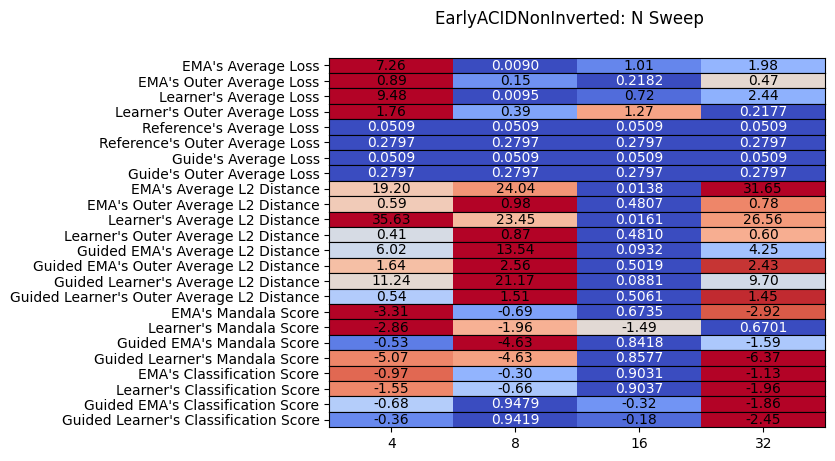

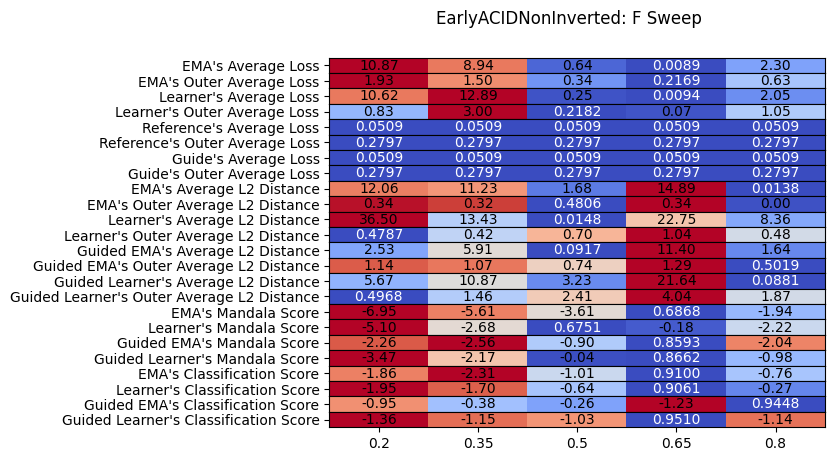

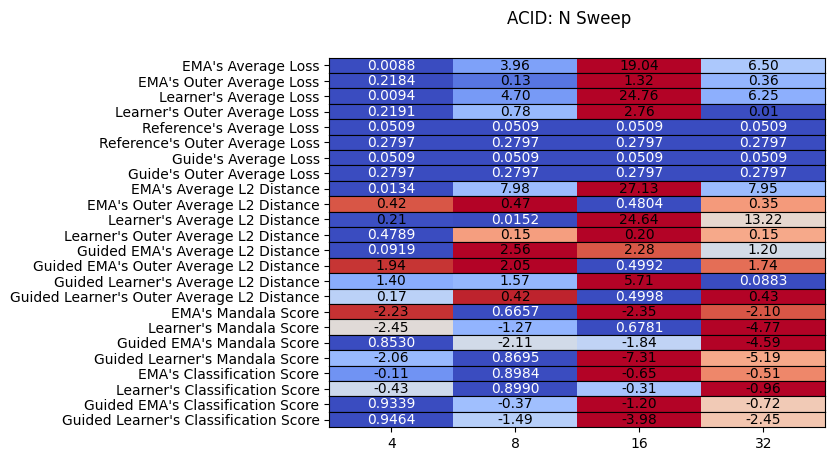

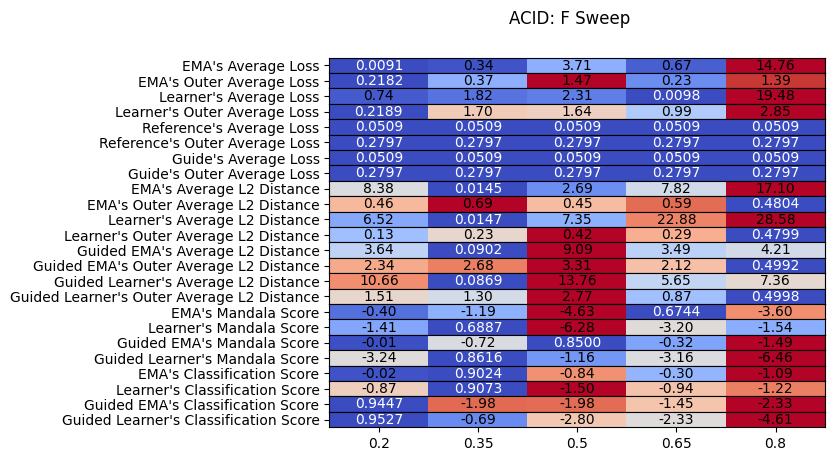

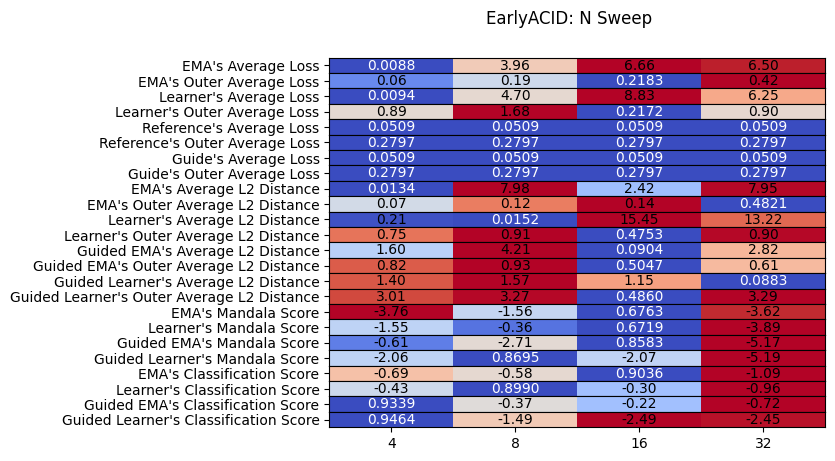

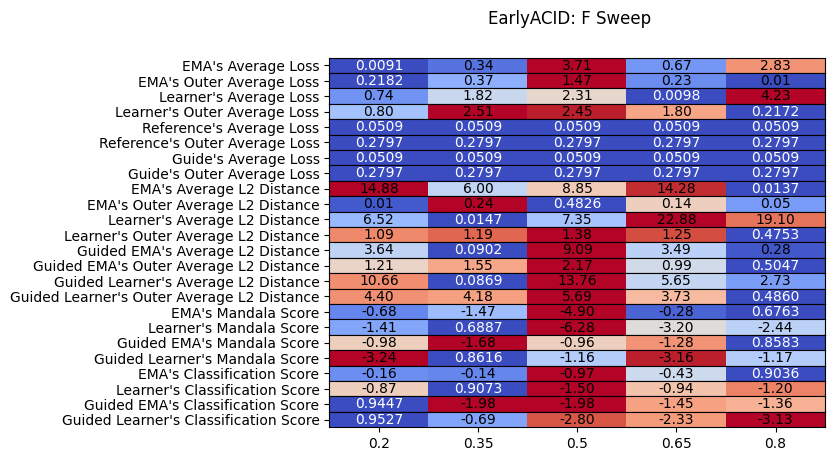

In [102]:
import warnings
warnings.filterwarnings("ignore")

show_values = True
show_percent = True

if show_values:
    aspect = "auto"
else: aspect = .5

for s in param_series:
    for f in true_folders[s]:
        for param, values in zip(["N","F"], [N_values, F_values]):
            fig, axes = plt.subplots(nrows=len(test_keys), gridspec_kw=dict(hspace=0))
            plt.suptitle(f + ": " + param + " Sweep")
            for ax, k in zip(axes, test_keys):
                if "Score" in test_names[k]:
                    cmap = "coolwarm_r"
                    operation = max
                else: 
                    cmap = "coolwarm" # Blue is good, red is bad
                    operation = min
                ax.imshow(np.array(param_results[s][f][param][k]).reshape((1,len(values))), cmap=cmap, aspect=aspect)
                if show_values:
                    for idx, metric in enumerate(param_results[s][f][param][k]):
                        if metric == operation(param_results[s][f][param][k]):
                            color = "w"
                            metric = f"{metric:.4f}"
                        else: 
                            color = "k"
                            if show_percent: 
                                metric = metric/operation(param_results[s][f][param][k]) - 1
                                metric = f"{100*metric:.2f}"
                            else:
                                metric = f"{metric:.4f}"
                        ax.text(idx, 0, metric, ha='center', va='center', color=color)
                ax.set_yticks([0],[test_names[k]])
            for i in range(len(axes)-1):
                axes[i].xaxis.set_visible(False)
            axes[-1].set_xticks(range(len(values)), values)